## Postprocessing Trained Surrogate Constructed for for the Mass-Spring-Damper Model 

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow                         as tf
from tensorflow                           import keras
from tensorflow                           import train
from tensorflow.keras                     import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras                     import regularizers
from tensorflow.keras                     import optimizers
from tensorflow.keras                     import losses
from tensorflow.keras                     import callbacks
from tensorflow.python.ops                import array_ops
from sklearn.model_selection              import train_test_split

In [2]:
### Input Data

PathToRunFld    = WORKSPACE_PATH + '/ROMNet/SMD_Test4/'
PathToParamsFld = PathToRunFld   + '/Params/'

OutputDir = WORKSPACE_PATH+'/ROMNet/Data_10SMD_Clean/'
TestDir   = WORKSPACE_PATH+'/ROMNet/Data_10SMD_Clean_Test/'

NTraining  = 10
NTest      = 3
NSamples   = 300
Nt         = 100
tout       = np.linspace(0.,15.,Nt)
SOLVER     = 'Radau'

In [3]:
### Loading Surrogate

ModelFile = PathToRunFld + '/NNModel'
Model     = keras.models.load_model(ModelFile)
Model.summary()

MCFile         = PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(MCFile)
latest         = train.latest_checkpoint(checkpoint_dir)
Model.load_weights(latest)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
tf.split (TFOpLambda)           [(None, 2), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 2)            5           tf.split[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, 1)            3           tf.split[0][1]                   
______________________________________________________________________________________________

In [15]:
Trunk = keras.Model(Model.inputs, Model.layers[-7].output)
Trunk.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
tf.split (TFOpLambda)        [(None, 2), (None, 1)]    0         
_________________________________________________________________
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
Trunk0_HL1 (Dense)           (None, 32)                64        
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Trunk0_HL2 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0   

In [19]:
Branch1 = keras.Model(Model.inputs, Model.layers[-8].output)
Branch1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
tf.split (TFOpLambda)        [(None, 2), (None, 1)]    0         
_________________________________________________________________
normalization_1 (Normalizati (None, 2)                 5         
_________________________________________________________________
Branch0_HL1 (Dense)          (None, 32)                96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
Branch0_HL2 (Dense)          (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0   

In [20]:
Branch2 = keras.Model(Model.inputs, Model.layers[-6].output)
Branch2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
tf.split (TFOpLambda)        [(None, 2), (None, 1)]    0         
_________________________________________________________________
normalization_1 (Normalizati (None, 2)                 5         
_________________________________________________________________
Branch1_HL1 (Dense)          (None, 32)                96        
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
Branch1_HL2 (Dense)          (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0   

In [4]:
### Defining ODE and its Parameters

from scipy.integrate import solve_ivp

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

iVar =  1


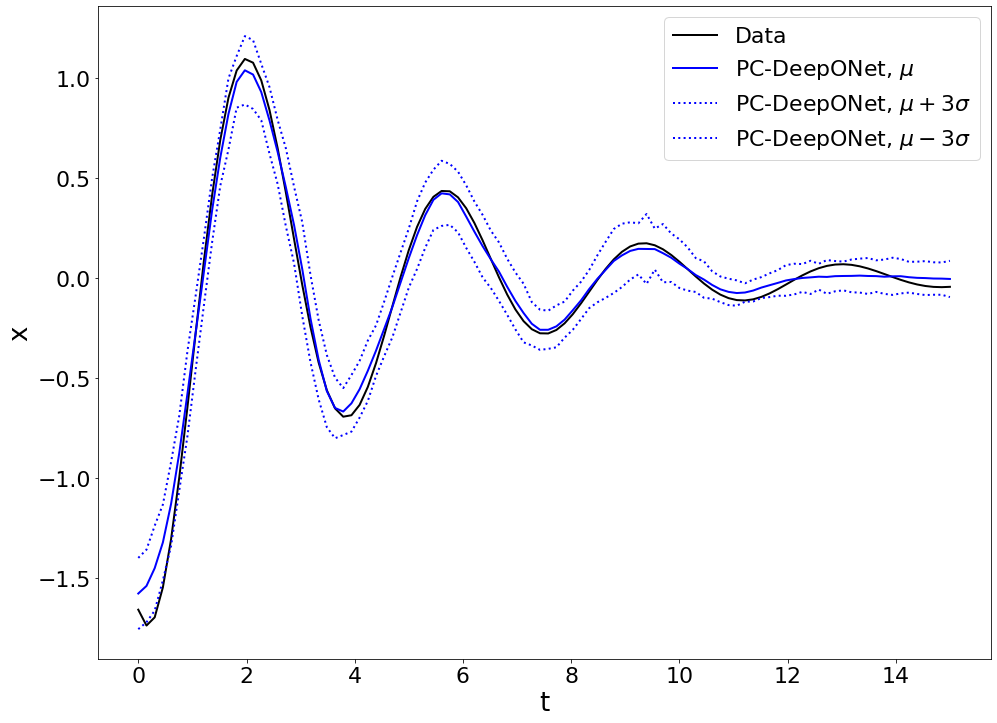

In [24]:
### Evaluating on Training Data

FileName  = OutputDir + '/Input.csv'
Data      = pd.read_csv(FileName, header=0)
Input     = Data.to_numpy()
VarNames  = list(Data.columns)
u1        = np.unique(Input[:,1])
u2        = np.unique(Input[:,2])

for iTraining in range(1):#NTraining):

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], np.array([u1[iTraining], u2[iTraining]]), method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = np.array([u1[iTraining], u2[iTraining]])*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)

    ### Sampling NN
    yMat_sum   = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
    yMat_sqr   = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
    yTrunk_sum = np.zeros((yMatOrig.shape[0], 32))
    yTrunk_sqr = np.zeros((yMatOrig.shape[0], 32))

    for iSample in range(NSamples):
        yMat_     = Model.predict(InputPred)    
        yMat_sum += yMat_
        yMat_sqr += yMat_**2
        
        yTrunk      = Trunk.predict(InputPred)
        yTrunk_sum += yTrunk
        yTrunk_sqr += yTrunk**2

    yMat_mean = yMat_sum/NSamples
    yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
    yMat_p1   = yMat_mean + 1.*yMat_std
    yMat_m1   = yMat_mean - 1.*yMat_std
    yMat_p2   = yMat_mean + 2.*yMat_std
    yMat_m2   = yMat_mean - 2.*yMat_std
    yMat_p3   = yMat_mean + 3.*yMat_std
    yMat_m3   = yMat_mean - 3.*yMat_std

    
    ## Plotting
    VarOI = 'x'
    for iVar in range(1,len(VarNames)):
        if (VarNames[iVar] == VarOI):
            print('iVar = ', iVar)
            break

    fig = plt.figure(figsize=(16, 12))
    plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
    plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=r'PC-DeepONet, $\mu$')
    plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu+3\sigma$')
    plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu-3\sigma$')
    plt.xlabel('t')
    plt.ylabel(VarOI)
    plt.legend()
    plt.show()

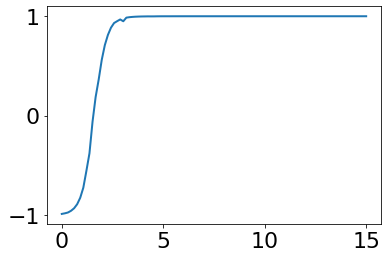

In [31]:
iN = 3
plt.plot(tPred, yTrunk[:,iN])

u0 =  [-1.40915037 -0.43249737]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


iVar =  1


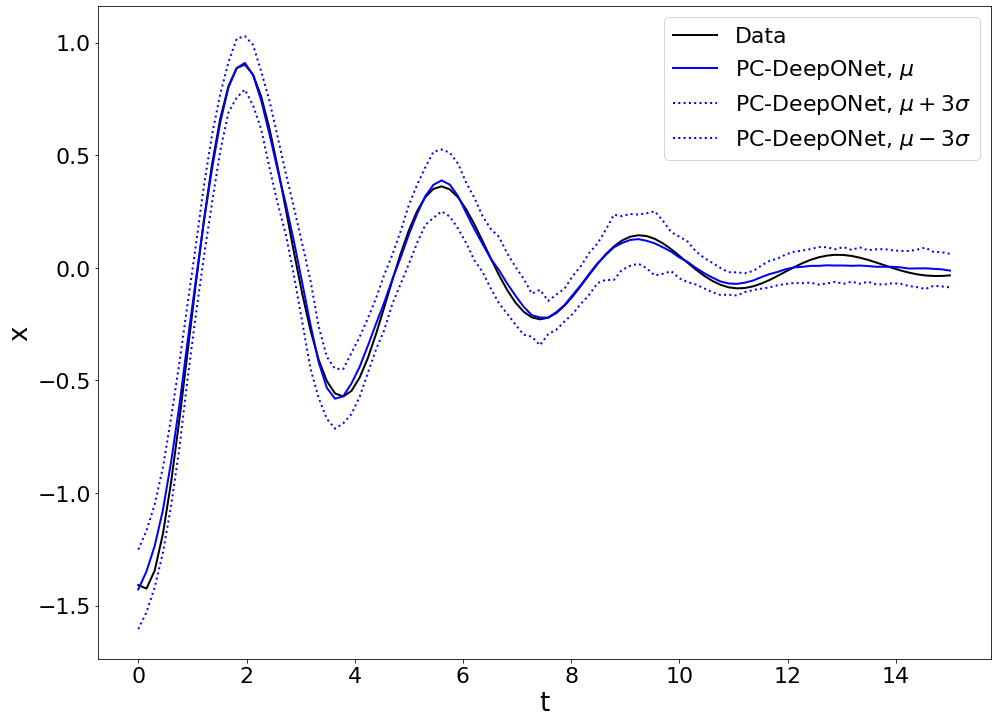

u0 =  [-0.81873509 -0.13433945]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


iVar =  1


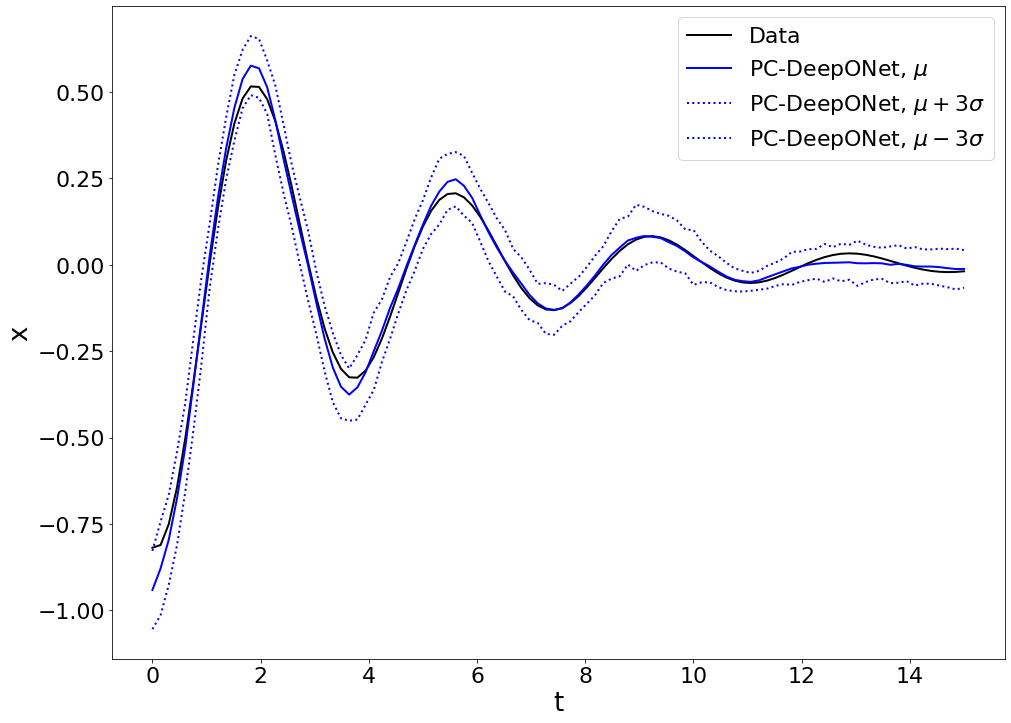

u0 =  [-0.69370591 -0.1054349 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


iVar =  1


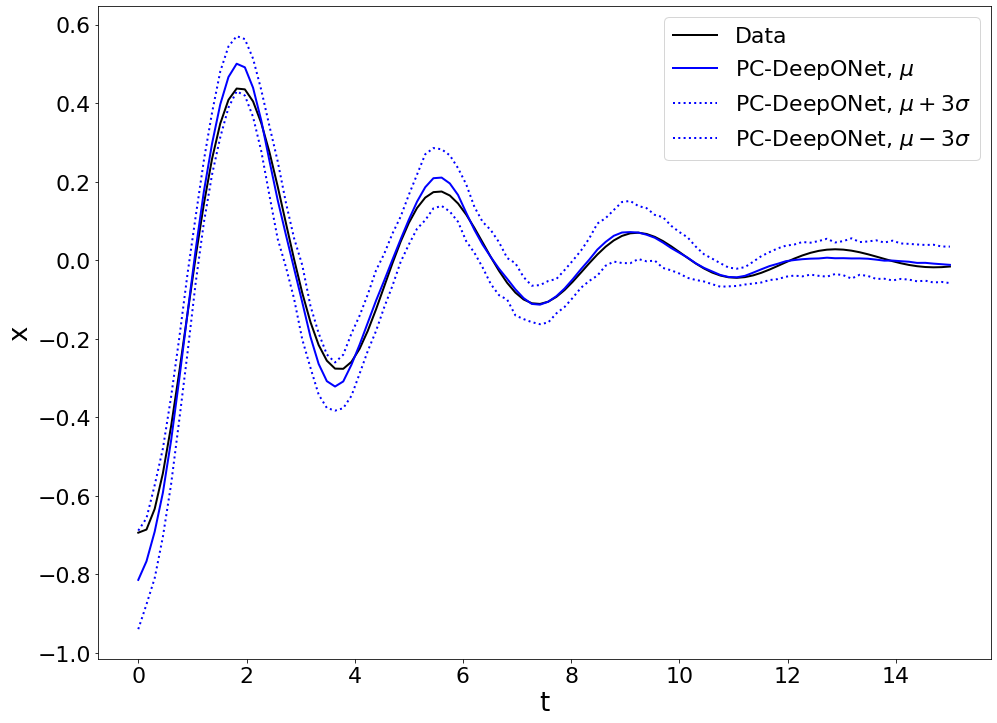

u0 =  [0.38800195 0.02350017]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


iVar =  1


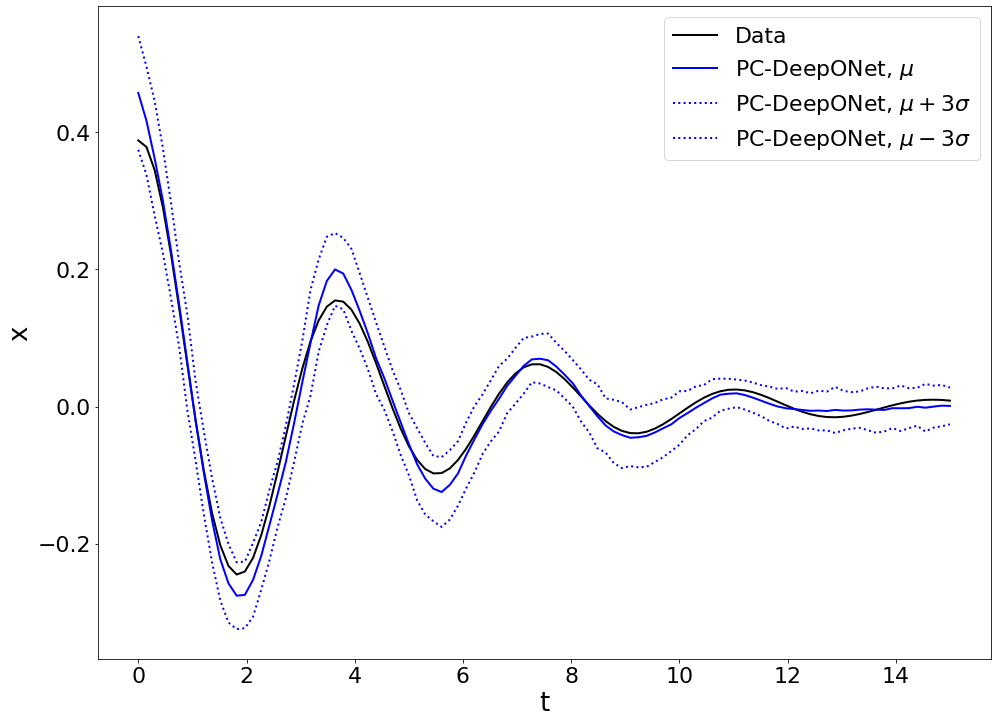

u0 =  [0.49547463 0.19423564]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


iVar =  1


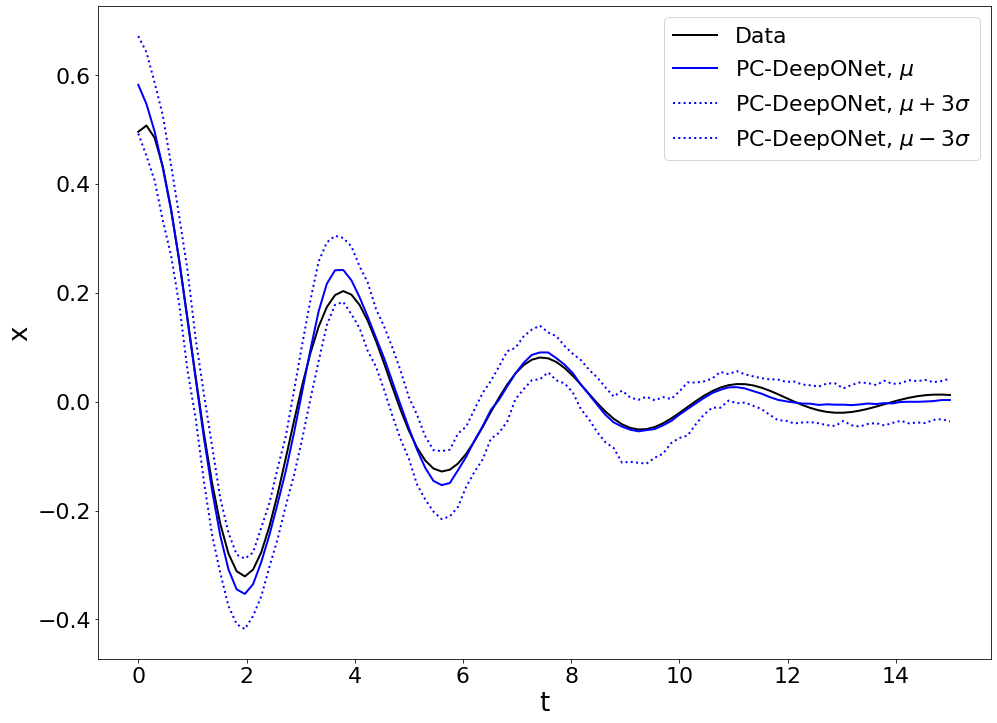

u0 =  [1.03089013 0.31640317]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


iVar =  1


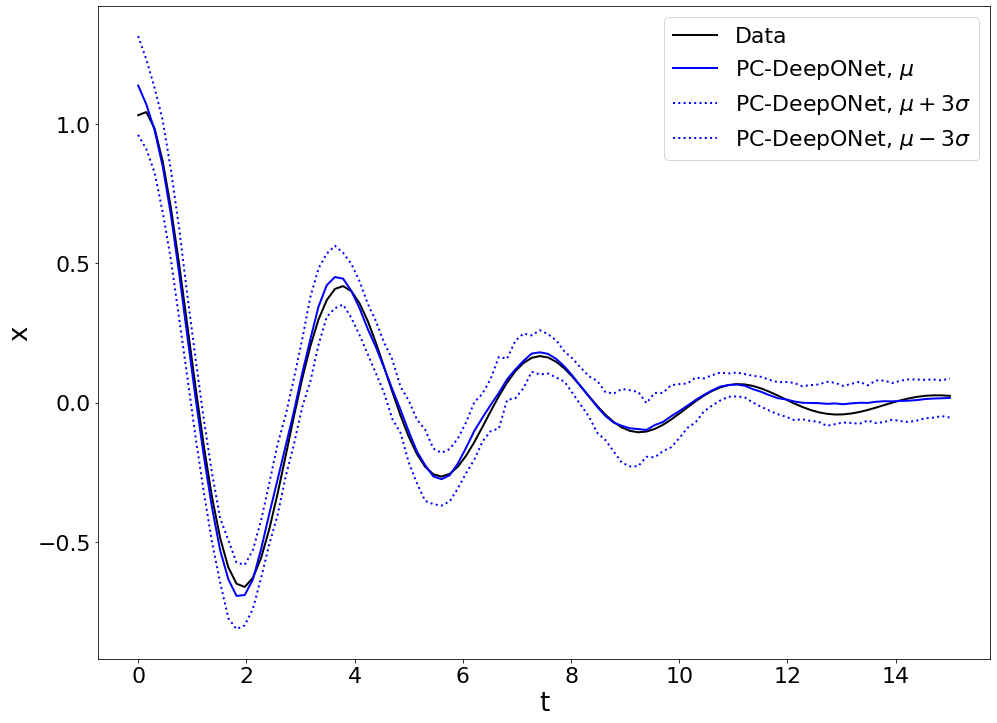

In [6]:
### Evaluating on Test Data

FileName  = TestDir + '/Input.csv'
Data      = pd.read_csv(FileName, header=0)
Input     = Data.to_numpy()
u1        = np.unique(Input[:,1])
u2        = np.unique(Input[:,2])

for iTest in range(2,NTest+5):
    
    print('u0 = ', np.array([u1[iTest], u2[iTest]]))

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], np.array([u1[iTest], u2[iTest]]), method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = np.array([u1[iTest], u2[iTest]])*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)

    ### Sampling NN
    yMat_sum = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
    yMat_sqr = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))

    for iSample in range(NSamples):
        yMat_ = Model.predict(InputPred)    
        yMat_sum += yMat_
        yMat_sqr += yMat_**2

    yMat_mean = yMat_sum/NSamples
    yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
    yMat_p1   = yMat_mean + 1.*yMat_std
    yMat_m1   = yMat_mean - 1.*yMat_std
    yMat_p2   = yMat_mean + 2.*yMat_std
    yMat_m2   = yMat_mean - 2.*yMat_std
    yMat_p3   = yMat_mean + 3.*yMat_std
    yMat_m3   = yMat_mean - 3.*yMat_std

    
    ## Plotting
    VarOI = 'x'
    for iVar in range(1,len(VarNames)):
        if (VarNames[iVar] == VarOI):
            print('iVar = ', iVar)
            break

    fig = plt.figure(figsize=(16, 12))
    plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
    plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=r'PC-DeepONet, $\mu$')
    plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu+3\sigma$')
    plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu-3\sigma$')
    plt.xlabel('t')
    plt.ylabel(VarOI)
    plt.legend()
    plt.show()